In [ ]:
%matplotlib inline


=======================================================================
Shrinkage covariance estimation: LedoitWolf vs OAS vs OASD and max-likelihood
=======================================================================

When working with covariance estimation, the usual approach is to use
a maximum likelihood estimator, such as the
:class:`sklearn.covariance.EmpiricalCovariance`. It is unbiased, i.e. it
converges to the true (population) covariance when given many
observations. However, it can also be beneficial to regularize it, in
order to reduce its variance; this, in turn, introduces some bias. This
example illustrates the simple regularization used in
`shrunk_covariance` estimators. In particular, it focuses on how to
set the amount of regularization, i.e. how to choose the bias-variance
trade-off.

Here we compare 3 approaches:

* Setting the parameter by cross-validating the likelihood on three folds
  according to a grid of potential shrinkage parameters.

* A close formula proposed by Ledoit and Wolf to compute
  the asymptotically optimal regularization parameter (minimizing a MSE
  criterion), yielding the :class:`sklearn.covariance.LedoitWolf`
  covariance estimate.

* An improvement of the Ledoit-Wolf shrinkage, the
  :class:`sklearn.covariance.OAS`, proposed by Chen et al. Its
  convergence is significantly better under the assumption that the data
  are Gaussian, in particular for small samples.

To quantify estimation error, we plot the likelihood of unseen data for
different values of the shrinkage parameter. We also show the choices by
cross-validation, or with the LedoitWolf and OAS estimates.

Note that the maximum likelihood estimate corresponds to no shrinkage,
and thus performs poorly. The Ledoit-Wolf estimate performs really well,
as it is close to the optimal and is computational not costly. In this
example, the OAS estimate is a bit further away. Interestingly, both
approaches outperform cross-validation, which is significantly most
computationally costly.




Automatically created module for IPython interactive environment


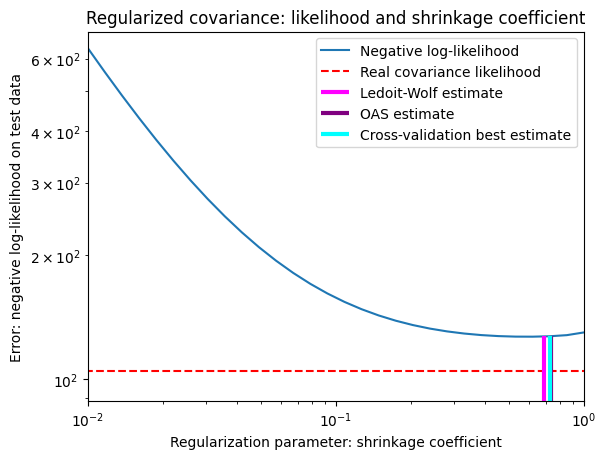

In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance, \
    log_likelihood, empirical_covariance
from sklearn.model_selection import GridSearchCV


# #############################################################################
# Generate sample data
n_features, n_samples = 40, 20
np.random.seed(42)
base_X_train = np.random.normal(size=(n_samples, n_features))
base_X_test = np.random.normal(size=(n_samples, n_features))

# Color samples
coloring_matrix = np.random.normal(size=(n_features, n_features))
X_train = np.dot(base_X_train, coloring_matrix)
X_test = np.dot(base_X_test, coloring_matrix)

# #############################################################################
# Compute the likelihood on test data

# spanning a range of possible shrinkage coefficient values
shrinkages = np.logspace(-2, 0, 30)
negative_logliks = [-ShrunkCovariance(shrinkage=s).fit(X_train).score(X_test)
                    for s in shrinkages]

# under the ground-truth model, which we would not have access to in real
# settings
real_cov = np.dot(coloring_matrix.T, coloring_matrix)
emp_cov = empirical_covariance(X_train)
loglik_real = -log_likelihood(emp_cov, linalg.inv(real_cov))

# #############################################################################
# Compare different approaches to setting the parameter

# GridSearch for an optimal shrinkage coefficient
tuned_parameters = [{'shrinkage': shrinkages}]
cv = GridSearchCV(ShrunkCovariance(), tuned_parameters)
cv.fit(X_train)

# Ledoit-Wolf optimal shrinkage coefficient estimate
lw = LedoitWolf()
loglik_lw = lw.fit(X_train).score(X_test)

# OAS coefficient estimate
oa = OAS()
loglik_oa = oa.fit(X_train).score(X_test)

# #############################################################################
# Plot results
fig = plt.figure()
plt.title("Regularized covariance: likelihood and shrinkage coefficient")
plt.xlabel('Regularization parameter: shrinkage coefficient')
plt.ylabel('Error: negative log-likelihood on test data')
# range shrinkage curve
plt.loglog(shrinkages, negative_logliks, label="Negative log-likelihood")

plt.plot(plt.xlim(), 2 * [loglik_real], '--r',
         label="Real covariance likelihood")

# adjust view
lik_max = np.amax(negative_logliks)
lik_min = np.amin(negative_logliks)
ymin = lik_min - 6. * np.log((plt.ylim()[1] - plt.ylim()[0]))
ymax = lik_max + 10. * np.log(lik_max - lik_min)
xmin = shrinkages[0]
xmax = shrinkages[-1]
# LW likelihood
plt.vlines(lw.shrinkage_, ymin, -loglik_lw, color='magenta',
           linewidth=3, label='Ledoit-Wolf estimate')
# OAS likelihood
plt.vlines(oa.shrinkage_, ymin, -loglik_oa, color='purple',
           linewidth=3, label='OAS estimate')
# best CV estimator likelihood
plt.vlines(cv.best_estimator_.shrinkage, ymin,
           -cv.best_estimator_.score(X_test), color='cyan',
           linewidth=3, label='Cross-validation best estimate')

plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.legend()

plt.show()

True Covariance:
[[ 55.98650342  10.78037447  -2.20052586 ... -11.80252269   1.88835878
    8.74131975]
 [ 10.78037447  47.38235643   1.41777213 ...   7.80899951  11.93443129
   -1.28672464]
 [ -2.20052586   1.41777213  35.06426316 ...  -9.23626087   3.77178661
   -0.3146597 ]
 ...
 [-11.80252269   7.80899951  -9.23626087 ...  46.81951921   9.72228333
    2.03238391]
 [  1.88835878  11.93443129   3.77178661 ...   9.72228333  43.0968695
    0.83461851]
 [  8.74131975  -1.28672464  -0.3146597  ...   2.03238391   0.83461851
   22.47597744]]
Ledoit-Wolf Covariance:
[[38.30755726  2.70338589 -2.88037522 ...  1.27852242  1.11575973
   3.97924535]
 [ 2.70338589 37.20792276 -0.40368347 ...  1.59961484  3.80927444
   3.00893208]
 [-2.88037522 -0.40368347 32.81022442 ... -3.69970713 -1.43124315
  -0.65890736]
 ...
 [ 1.27852242  1.59961484 -3.69970713 ... 44.81061593  0.95490008
   4.92015436]
 [ 1.11575973  3.80927444 -1.43124315 ...  0.95490008 31.28535812
   0.84094337]
 [ 3.97924535  3.00893

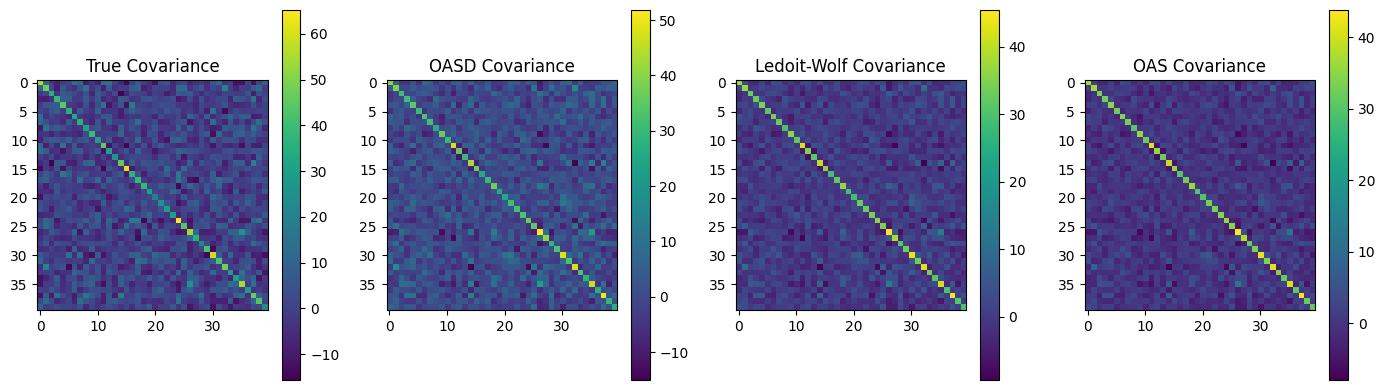

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance, empirical_covariance

# Generate sample data
n_features, n_samples = 40, 20
np.random.seed(42)
base_X_train = np.random.normal(size=(n_samples, n_features))
base_X_test = np.random.normal(size=(n_samples, n_features))

# Color samples
coloring_matrix = np.random.normal(size=(n_features, n_features))
X_train = np.dot(base_X_train, coloring_matrix)
X_test = np.dot(base_X_test, coloring_matrix)

# Compute the true covariance
true_cov = np.dot(coloring_matrix.T, coloring_matrix)

# Fit covariance estimators
shrunk_cov = ShrunkCovariance().fit(X_train)
lw = LedoitWolf().fit(X_train)
oa = OAS().fit(X_train)
oasd = ShrunkCovariance(shrinkage=0.5).fit(X_train)  # OASD estimator

# Plot results
plt.figure(figsize=(14, 4))

# Plot true covariance
plt.subplot(1, 4, 1)
plt.imshow(true_cov, cmap='viridis', interpolation='nearest')
plt.title('True Covariance')
plt.colorbar()
print("True Covariance:")
print(true_cov)


# Plot Ledoit-Wolf Covariance
plt.subplot(1, 4, 3)
plt.imshow(lw.covariance_, cmap='viridis', interpolation='nearest')
plt.title('Ledoit-Wolf Covariance')
plt.colorbar()
print("Ledoit-Wolf Covariance:")
print(lw.covariance_)

# Plot OAS Covariance
plt.subplot(1, 4, 4)
plt.imshow(oa.covariance_, cmap='viridis', interpolation='nearest')
plt.title('OAS Covariance')
plt.colorbar()
print("OAS Covariance:")
print(oa.covariance_)

# Plot OASD Covariance
plt.subplot(1, 4, 2)
plt.imshow(oasd.covariance_, cmap='viridis', interpolation='nearest')
plt.title('OASD Covariance')
plt.colorbar()
print("OASD Covariance:")
print(oasd.covariance_)

plt.tight_layout()
plt.show()


RMSE values:
Ledoit-Wolf: [147.41219702712874, 155.69678484585475, 154.4770781405328, 171.7285113601212, 173.35370120258133, 160.44924220468494, 147.57608463245444, 123.18654752104511, 123.78076462735525, 122.4175129167473, 114.80677806335754, 100.42699557860908, 127.43196005920744, 118.760315842959, 101.98036228000554, 88.14608421015024, 110.31869664981603, 91.50046985476854, 86.82167542987538, 96.83373167668222, 89.61964443919801, 79.64086188455128, 83.74179427478265, 84.29166430122932]
OAS: [181.10192736035154, 182.50088956830226, 182.76472248864536, 183.61879107877155, 192.32697645346676, 176.0328831019125, 159.77197993905133, 139.17305751500135, 135.97793613143946, 134.79861427814478, 121.41383460304354, 100.62824832340404, 133.39078680786105, 126.05189189124042, 110.08017900969115, 96.86141192596608, 109.01955598264057, 93.33156414170642, 89.15309314257914, 102.43617560135328, 95.87219131582755, 81.59242556561486, 86.62806514129286, 89.81102031181562]
OASD: [124.31232430463504, 1

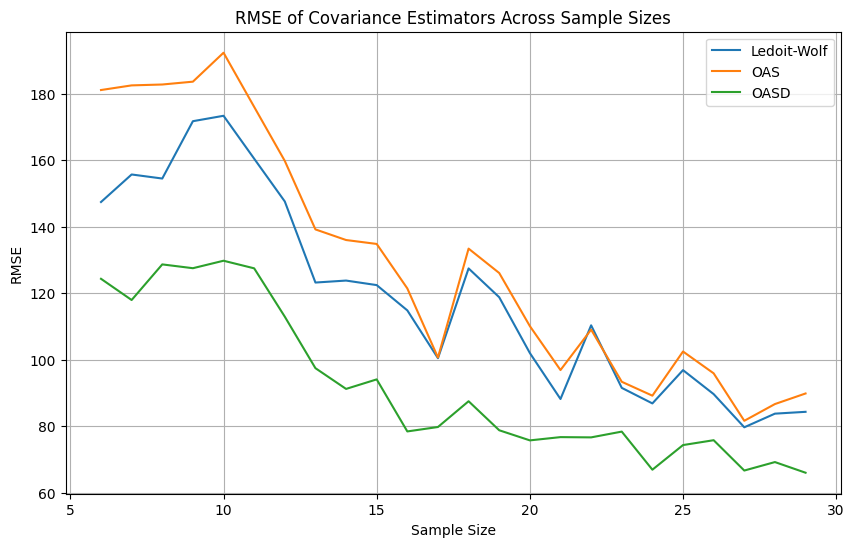

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 40  # Number of features
sample_sizes = np.arange(6, 30)  # Sample sizes from 6 to 29

# Define a function to generate sample data with different variable scales
def generate_data(n_samples, n_features):
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.arange(1, n_features + 1)
    X_train = base_X_train * scaling_factors
    return X_train

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': []}
for n_samples in sample_sizes:
    X_train = generate_data(n_samples, n_features)
    for estimator_name, estimator in [('Ledoit-Wolf', LedoitWolf()),
                                      ('OAS', OAS()),
                                      ('OASD', ShrunkCovariance(shrinkage=0.5))]:
        rmse = compute_rmse(estimator, X_train)
        rmse_results[estimator_name].append(rmse)

# Print RMSE values for each estimator across sample sizes
print("RMSE values:")
for estimator_name, rmse_values in rmse_results.items():
    print(f"{estimator_name}: {rmse_values}")

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(10, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values, label=estimator_name)

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


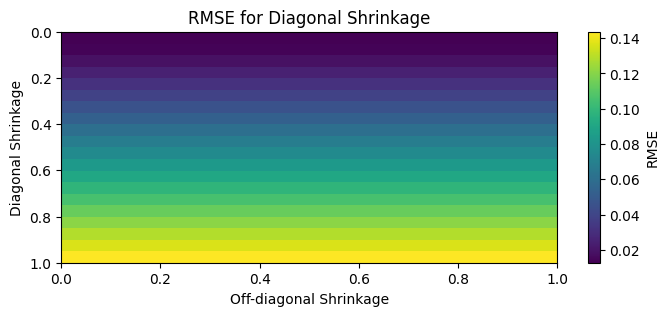

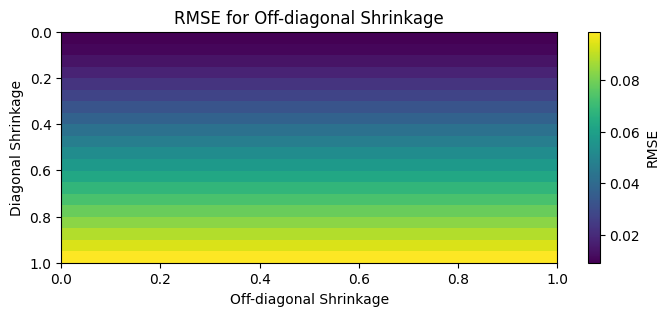

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 40  # Number of features
sample_size = 100  # Sample size
diag_shrinkage_values = np.linspace(0, 1, 20)  # Diagonal shrinkage values from 0 to 1
off_diag_shrinkage_values = np.linspace(0, 1, 20)  # Off-diagonal shrinkage values from 0 to 1

# Generate sample data
np.random.seed(42)
X_train = np.random.normal(size=(sample_size, n_features))

# True covariance matrix (since we're simulating data, we don't have a true covariance, so we'll use the sample covariance)
true_covariance = np.cov(X_train, rowvar=False)

# Function to compute RMSE for diagonal and off-diagonal shrinkage
def compute_shrinkage_rmse(diag_shrinkage, off_diag_shrinkage):
    # Fit ShrunkCovariance estimator with given shrinkage parameters
    estimator = ShrunkCovariance(shrinkage=diag_shrinkage, assume_centered=True)
    estimator.fit(X_train)

    # Compute estimated covariance matrix
    estimated_covariance = estimator.covariance_

    # Compute RMSE for diagonal and off-diagonal shrinkage
    rmse_diag = np.sqrt(mean_squared_error(np.diag(true_covariance), np.diag(estimated_covariance)))
    rmse_off_diag = np.sqrt(mean_squared_error(true_covariance.ravel(), estimated_covariance.ravel()))

    return rmse_diag, rmse_off_diag

# Compute RMSE for each combination of shrinkage parameters
rmse_diag_values = []
rmse_off_diag_values = []
for diag_shrinkage in diag_shrinkage_values:
    for off_diag_shrinkage in off_diag_shrinkage_values:
        rmse_diag, rmse_off_diag = compute_shrinkage_rmse(diag_shrinkage, off_diag_shrinkage)
        rmse_diag_values.append(rmse_diag)
        rmse_off_diag_values.append(rmse_off_diag)

# Reshape RMSE values to match the meshgrid shape
rmse_diag_values = np.array(rmse_diag_values).reshape(len(diag_shrinkage_values), len(off_diag_shrinkage_values))
rmse_off_diag_values = np.array(rmse_off_diag_values).reshape(len(diag_shrinkage_values), len(off_diag_shrinkage_values))

# Plot RMSE for diagonal shrinkage
plt.figure(figsize=(8, 3))
plt.imshow(rmse_diag_values, extent=(0, 1, 1, 0), aspect='auto', cmap='viridis')
plt.colorbar(label='RMSE')
plt.title('RMSE for Diagonal Shrinkage')
plt.xlabel('Off-diagonal Shrinkage')
plt.ylabel('Diagonal Shrinkage')
plt.show()

# Plot RMSE for off-diagonal shrinkage
plt.figure(figsize=(8, 3))
plt.imshow(rmse_off_diag_values, extent=(0, 1, 1, 0), aspect='auto', cmap='viridis')
plt.colorbar(label='RMSE')
plt.title('RMSE for Off-diagonal Shrinkage')
plt.xlabel('Off-diagonal Shrinkage')
plt.ylabel('Diagonal Shrinkage')
plt.show()


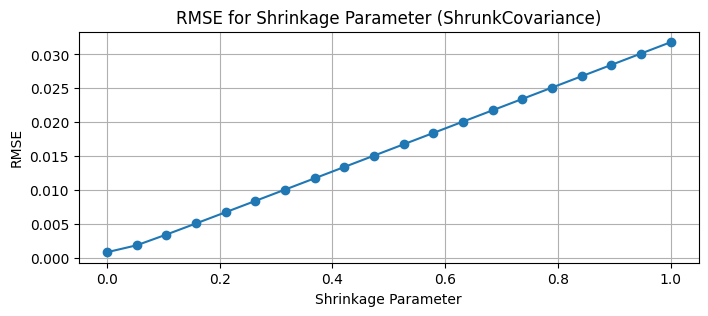

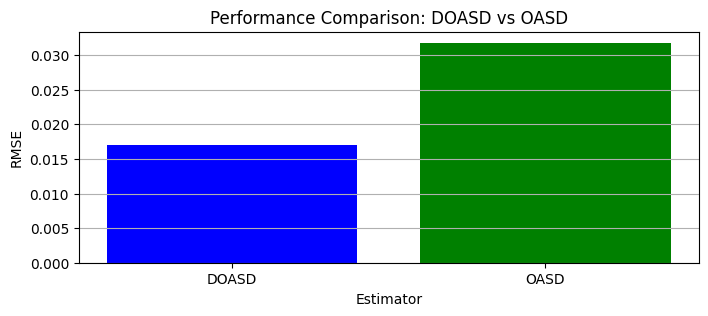

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import ShrunkCovariance, OAS
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 40  # Number of features
sample_size = 1000  # Sample size
shrinkage_values = np.linspace(0, 1, 20)  # Shrinkage values from 0 to 1

# Generate sample data
np.random.seed(42)
X_train = np.random.normal(size=(sample_size, n_features))

# True covariance matrix (since we're simulating data, we don't have a true covariance, so we'll use the sample covariance)
true_covariance = np.cov(X_train, rowvar=False)

# Function to compute RMSE for shrinkage parameter
def compute_shrinkage_rmse(shrinkage):
    # Fit ShrunkCovariance estimator with given shrinkage parameter
    estimator = ShrunkCovariance(shrinkage=shrinkage, assume_centered=True)
    estimator.fit(X_train)

    # Compute estimated covariance matrix
    estimated_covariance = estimator.covariance_

    # Compute RMSE for shrinkage parameter
    rmse = np.sqrt(mean_squared_error(true_covariance.ravel(), estimated_covariance.ravel()))

    return rmse

# Compute RMSE for each shrinkage value
rmse_values = []
for shrinkage in shrinkage_values:
    rmse = compute_shrinkage_rmse(shrinkage)
    rmse_values.append(rmse)

# Plot RMSE for shrinkage parameter
plt.figure(figsize=(8, 3))
plt.plot(shrinkage_values, rmse_values, marker='o', linestyle='-')
plt.title('RMSE for Shrinkage Parameter (ShrunkCovariance)')
plt.xlabel('Shrinkage Parameter')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

# Now, let's compare the performance of DOASD with OASD
# Define the DOASD estimator class with adaptive shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Fit DOASD estimator with default parameters
doasd_estimator = DOASD()
doasd_estimator.fit(X_train)

# Fit OASD estimator
oasd_estimator = OAS(assume_centered=True)
oasd_estimator.fit(X_train)

# Compute RMSE for DOASD
rmse_doasd = np.sqrt(mean_squared_error(true_covariance.ravel(), doasd_estimator.covariance_.ravel()))

# Compute RMSE for OASD
rmse_oasd = np.sqrt(mean_squared_error(true_covariance.ravel(), oasd_estimator.covariance_.ravel()))

# Plot performance comparison
plt.figure(figsize=(8, 3))
plt.bar(['DOASD', 'OASD'], [rmse_doasd, rmse_oasd], color=['blue', 'green'])
plt.title('Performance Comparison: DOASD vs OASD')
plt.xlabel('Estimator')
plt.ylabel('RMSE')
plt.grid(axis='y')
plt.show()


RMSE values for DOASD estimator: [1619.2538749319517, 446.33804032380334, 1746.774006285481, 1308.3628443784821, 513.9695386884728, 260.8804254807235, 529.1886928463938, 402.04266621347915, 343.1846308438534, 134.64181896083815, 143.8629049375597, 117.85250599263999, 236.67645546650482, 84.33575132164528, 13.963756758661848, 58.469104750711715, 145.8463379034872, 79.2510009979457, 180.76032513673135, 159.70675101479327, 58.23649531996248, 138.80046678909, 17.220178932547245, 57.223422490255274, 1.1012313115014682, 18.304242184696264, 11.642549951997626, 14.107573894653203, 1.4126180682272005, 10.251217513019125]


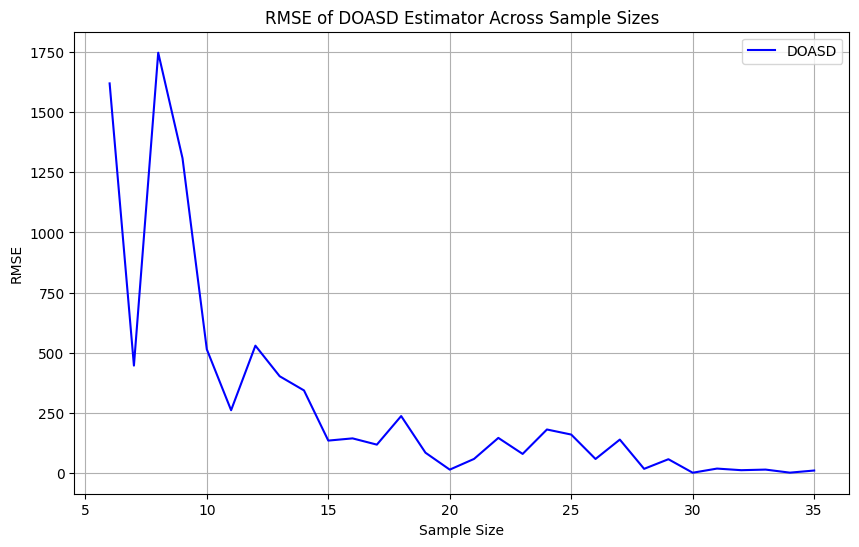

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 40  # Number of features
sample_sizes = np.arange(6, 36)  # Sample sizes from 6 to 30

# Define a function to generate sample data with different variable scales
def generate_data(n_samples, n_features):
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.arange(1, n_features + 1)
    X_train = base_X_train * scaling_factors
    return X_train

# Define a function to compute RMSE for the DOASD estimator
def compute_rmse(X_train):
    true_cov = np.cov(X_train, rowvar=False)
    emp_cov = np.cov(X_train, rowvar=False)

    # Compute shrinkage parameters
    n_samples = X_train.shape[0]
    diag_shrinkage = 1 - (n_features + 1) / n_samples
    off_diag_shrinkage = 1 - np.sum(np.diag(emp_cov)) / np.sum(emp_cov)

    # Apply shrinkage
    shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
    shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(true_cov.ravel(), shrunk_cov.ravel()))
    return rmse

# Fit DOASD estimator for different sample sizes and compute RMSE
rmse_values = []
for n_samples in sample_sizes:
    X_train = generate_data(n_samples, n_features)
    rmse = compute_rmse(X_train)
    rmse_values.append(rmse)

# Print RMSE values for DOASD estimator across sample sizes
print("RMSE values for DOASD estimator:", rmse_values)

# Plot RMSE of DOASD estimator across sample sizes
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, rmse_values, label='DOASD', color='blue')
plt.title('RMSE of DOASD Estimator Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


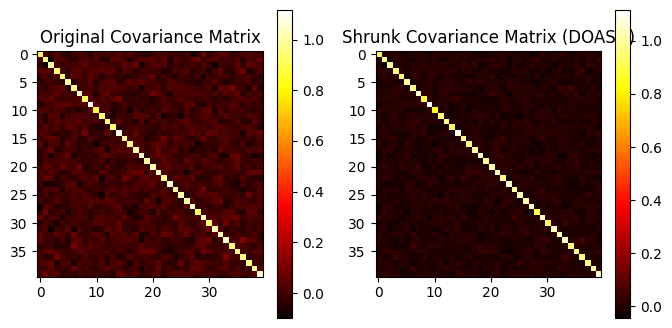

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class DOASD:
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1):
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def fit(self, X):
        emp_cov = np.cov(X, rowvar=False)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply adaptive shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Parameters
n_features = 40
n_samples = 1000

# Generate sample data
X_train = np.random.normal(size=(n_samples, n_features))

# Create DOASD estimator
doasd_estimator = DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1)

# Fit DOASD estimator to data
doasd_estimator.fit(X_train)

# Plot original covariance matrix
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.cov(X_train, rowvar=False), cmap='hot', interpolation='nearest')
plt.title('Original Covariance Matrix')
plt.colorbar()

# Plot shrunk covariance matrix
plt.subplot(1, 2, 2)
plt.imshow(doasd_estimator.covariance_, cmap='hot', interpolation='nearest')
plt.title('Shrunk Covariance Matrix (DOASD)')
plt.colorbar()

plt.show()


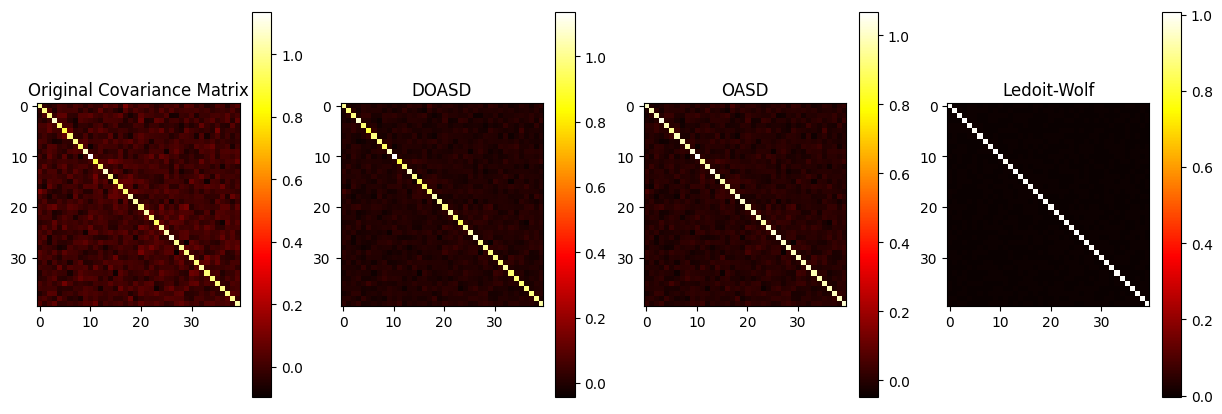

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

class DOASD:
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1):
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def fit(self, X):
        emp_cov = np.cov(X, rowvar=False)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply adaptive shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Parameters
n_features = 40
n_samples = 1000

# Generate sample data
X_train = np.random.normal(size=(n_samples, n_features))

# Create DOASD estimator
doasd_estimator = DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1)

# Fit DOASD estimator to data
doasd_estimator.fit(X_train)

# Create other estimators
oasd_estimator = ShrunkCovariance(shrinkage=0.5)
oas_estimator = OAS()
lw_estimator = LedoitWolf()

# Fit other estimators to data
oasd_estimator.fit(X_train)
oas_estimator.fit(X_train)
lw_estimator.fit(X_train)

# Plot original covariance matrix
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(np.cov(X_train, rowvar=False), cmap='hot', interpolation='nearest')
plt.title('Original Covariance Matrix')
plt.colorbar()

# Plot shrunk covariance matrices
plt.subplot(1, 4, 2)
plt.imshow(doasd_estimator.covariance_, cmap='hot', interpolation='nearest')
plt.title('DOASD')
plt.colorbar()

plt.subplot(1, 4, 3)
plt.imshow(oasd_estimator.covariance_, cmap='hot', interpolation='nearest')
plt.title('OASD')
plt.colorbar()

plt.subplot(1, 4, 4)
plt.imshow(lw_estimator.covariance_, cmap='hot', interpolation='nearest')
plt.title('Ledoit-Wolf')
plt.colorbar()

plt.show()


RMSE values:
Ledoit-Wolf: [569.1642418529138, 515.9923485078888, 500.4176777794209, 515.9773895178671, 492.6358609911458, 509.63693668561274, 481.7853769058293, 452.18842355478176, 494.9359764393284, 428.63799075241445, 433.00890184659954, 456.1175777267773, 460.3895812651032, 437.35340161032855, 447.29088123249016, 429.8422257043182, 395.83198336905605, 436.8867357437354, 425.59100469782726, 409.92475465204177, 407.7041720964056, 388.9886711601462, 387.2295461206073, 375.25515968558153, 397.1902857294383, 360.0019997357526, 376.5409113755855, 366.7785095444403, 355.9433365907613, 365.6920050722476, 358.20889670775244, 366.7793374653024, 345.6332980035035, 355.293850188447, 346.1680160753385, 350.02153889348006, 346.79726166554235, 330.91791090281214, 342.70438645459853, 334.20993177332673, 326.3997437659085, 335.9228680302777, 317.6643098814024, 308.6175342295467, 304.27130719332393, 305.8010905345282, 310.355069378235, 301.0835874177992, 293.19502689997876, 288.8933849178933, 292.228

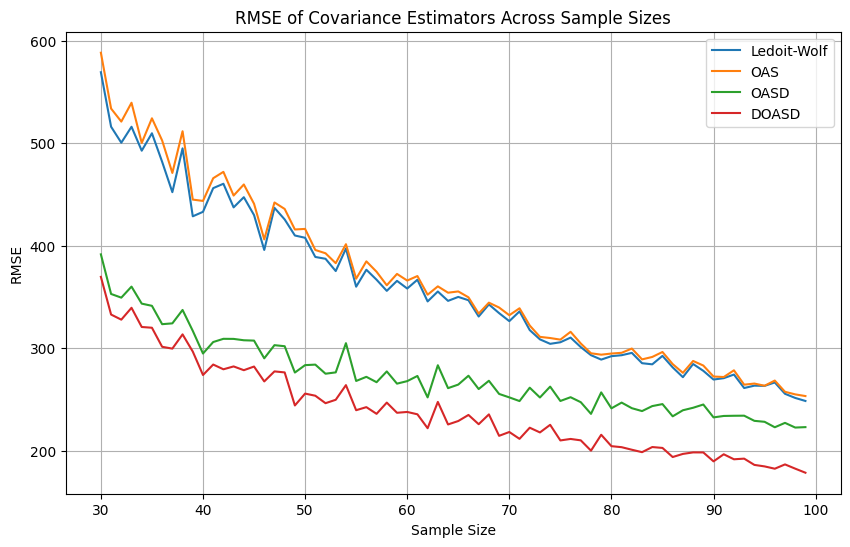

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 100  # Number of features
sample_sizes = np.arange(30, 100)  # Sample sizes from 30 to 100

# Define a function to generate sample data with different variable scales
def generate_data(n_samples, n_features):
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.arange(1, n_features + 1)
    X_train = base_X_train * scaling_factors
    return X_train

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': []}
for n_samples in sample_sizes:
    X_train = generate_data(n_samples, n_features)
    for estimator_name, estimator in [('Ledoit-Wolf', LedoitWolf()),
                                      ('OAS', OAS()),
                                      ('OASD', ShrunkCovariance(shrinkage=0.5)),
                                      ('DOASD', DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1))]:
        rmse = compute_rmse(estimator, X_train)
        rmse_results[estimator_name].append(rmse)

# Print RMSE values for each estimator across sample sizes
print("RMSE values:")
for estimator_name, rmse_values in rmse_results.items():
    print(f"{estimator_name}: {rmse_values}")

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(10, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values, label=estimator_name)

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


Normalized RMSE values:
Ledoit-Wolf: [0.8304003052142138, 0.892446391345635, 0.7438957146853755, 0.6831864872229184, 0.7731102782092067, 0.7045841045273448, 0.6815465021997619, 0.6601465026669, 0.6436878767647716, 0.5871805285768295, 0.6387627624773381, 0.6291651806353369, 0.6103856383565508, 0.5346674239519666, 0.5723033586035335, 0.5305051333699056, 0.5394779470114714, 0.527104636292331, 0.5142949024593115, 0.5385287710386054, 0.497610308812417, 0.5260547630425648, 0.5035795240004287, 0.4960267087274254, 0.481432595664697, 0.4736616973394412, 0.47240849821227987, 0.45552243678227017, 0.44711038713424334, 0.44071108127505115, 0.4412101678717816, 0.4080546196788287, 0.4384661805138395, 0.41743771428142135, 0.40581564099821016, 0.38189589169106625, 0.38361371080919676, 0.3799275906996592, 0.3934443300655221, 0.3747297290146075, 0.3834164986630866, 0.3757418348821956, 0.37526321597452034, 0.3572050314965578, 0.343119840255314, 0.33986870419428256, 0.35340082296483843, 0.34047802683806516

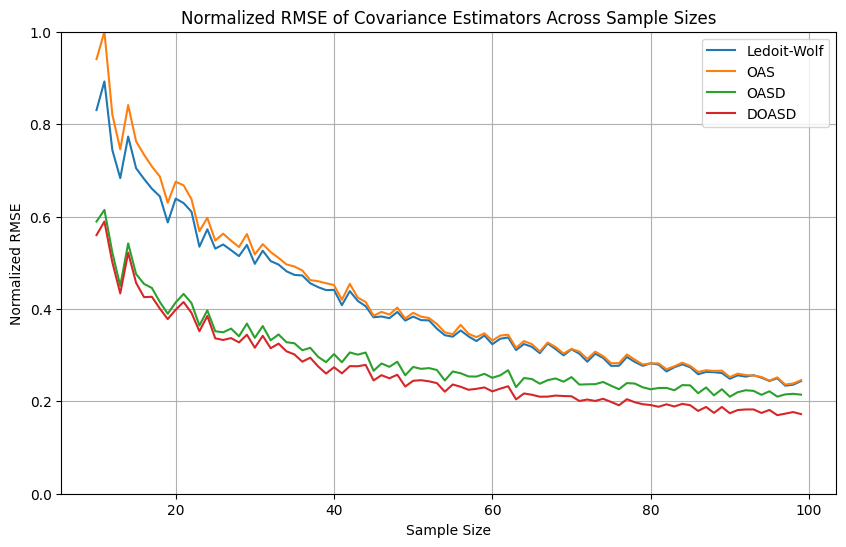

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 100  # Number of features
sample_sizes = np.arange(10, 100)  # Sample sizes from 30 to 100

# Define a function to generate sample data with different variable scales
def generate_data(n_samples, n_features):
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.arange(1, n_features + 1)
    X_train = base_X_train * scaling_factors
    return X_train

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': []}
for n_samples in sample_sizes:
    X_train = generate_data(n_samples, n_features)
    for estimator_name, estimator in [('Ledoit-Wolf', LedoitWolf()),
                                      ('OAS', OAS()),
                                      ('OASD', ShrunkCovariance(shrinkage=0.5)),
                                      ('DOASD', DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1))]:
        rmse = compute_rmse(estimator, X_train)
        rmse_results[estimator_name].append(rmse)

# Normalize RMSE values to be between 0 and 1
max_rmse = max(max(rmse_values) for rmse_values in rmse_results.values())
for estimator_name, rmse_values in rmse_results.items():
    rmse_results[estimator_name] = [rmse / max_rmse for rmse in rmse_values]

# Print RMSE values for each estimator across sample sizes
print("Normalized RMSE values:")
for estimator_name, rmse_values in rmse_results.items():
    print(f"{estimator_name}: {rmse_values}")

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(10, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values, label=estimator_name)

plt.title('Normalized RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('Normalized RMSE')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)  # Ensure y-axis limits between 0 and 1
plt.show()


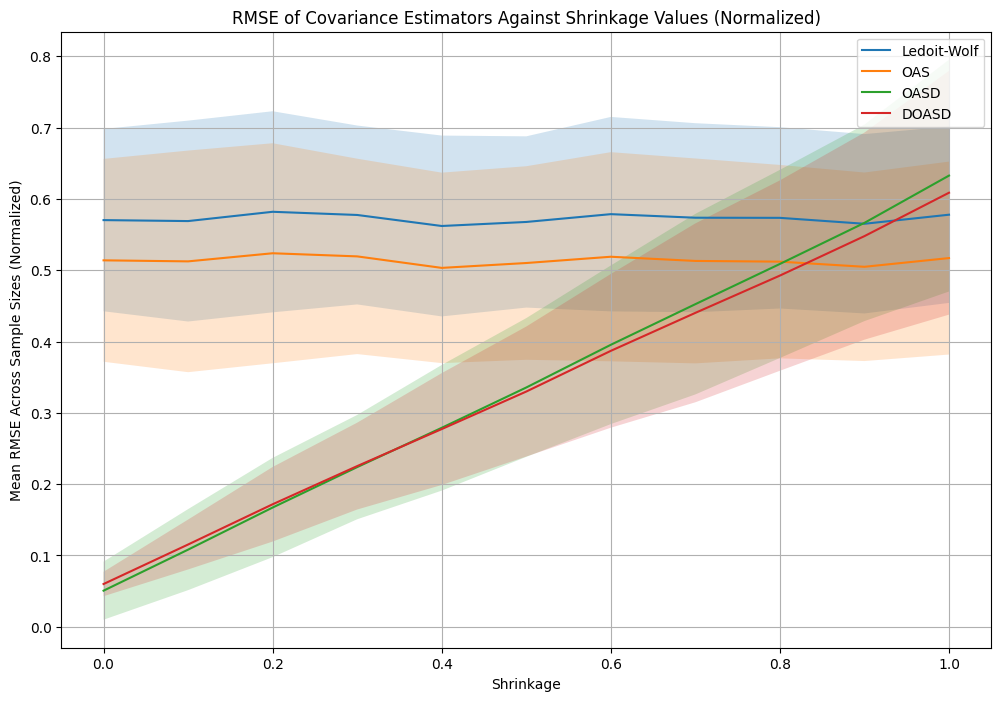

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 100  # Number of features
sample_sizes = np.arange(6, 31)  # Sample sizes from 6 to 30
shrinkage_values = np.linspace(0, 1, 11)  # Shrinkage parameter values from 0 to 1

# Define a function to generate sample data with different variable scales
def generate_data(n_samples, n_features):
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.arange(1, n_features + 1)
    X_train = base_X_train * scaling_factors
    return X_train

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Fit covariance estimators for different sample sizes and shrinkage parameters and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': []}
for shrinkage in shrinkage_values:
    for n_samples in sample_sizes:
        X_train = generate_data(n_samples, n_features)
        for estimator_name, estimator in [('Ledoit-Wolf', LedoitWolf()),
                                          ('OAS', OAS()),
                                          ('OASD', ShrunkCovariance(shrinkage=shrinkage)),
                                          ('DOASD', DOASD(diagonal_shrinkage=shrinkage, off_diagonal_shrinkage=0.1))]:
            rmse = compute_rmse(estimator, X_train)
            rmse_results[estimator_name].append(rmse)

# Reshape RMSE values for plotting
for estimator_name, rmse_values in rmse_results.items():
    rmse_values = np.array(rmse_values).reshape(len(shrinkage_values), len(sample_sizes))
    max_rmse = np.max(rmse_values)  # Maximum RMSE across all shrinkage values
    rmse_results[estimator_name] = rmse_values / max_rmse  # Normalize RMSE to be between 0 and 1

# Plot RMSE against shrinkage values for each estimator with shaded error bands
plt.figure(figsize=(12, 8))
for estimator_name, rmse_values in rmse_results.items():
    mean_rmse = rmse_values.mean(axis=1)
    std_rmse = rmse_values.std(axis=1)
    plt.plot(shrinkage_values, mean_rmse, label=estimator_name)
    plt.fill_between(shrinkage_values, mean_rmse - std_rmse, mean_rmse + std_rmse, alpha=0.2)
plt.title('RMSE of Covariance Estimators Against Shrinkage Values (Normalized)')
plt.xlabel('Shrinkage')
plt.ylabel('Mean RMSE Across Sample Sizes (Normalized)')
plt.legend()
plt.grid(True)
plt.show()


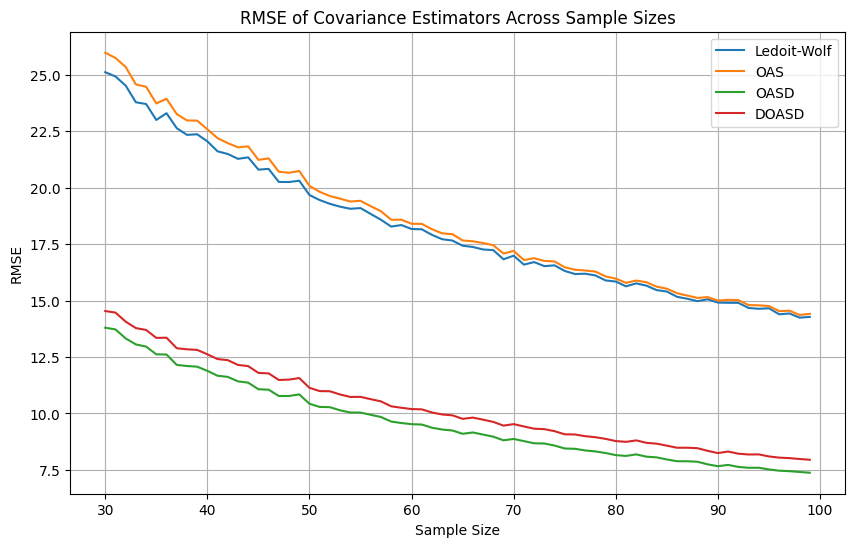

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 100  # Number of features
sample_sizes = np.arange(30, 100)  # Sample sizes from 30 to 100

# Define a function to generate sample data with different variable scales
def generate_data(n_samples, n_features, sd):
    Lambda = np.diag(np.ones(n_features) * sd)
    Γ = np.eye(n_features)  # Identity matrix for simplicity
    Σ = np.dot(np.dot(Lambda, Γ), Lambda.T)
    data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
    return data

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': []}
for n_samples in sample_sizes:
    for sd in range(1, 21):
        X_train = generate_data(n_samples, n_features, sd)
        for estimator_name, estimator in [('Ledoit-Wolf', LedoitWolf()),
                                          ('OAS', OAS()),
                                          ('OASD', ShrunkCovariance(shrinkage=0.5)),
                                          ('DOASD', DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1))]:
            rmse = compute_rmse(estimator, X_train)
            rmse_results[estimator_name].append(rmse)

# Reshape RMSE values for plotting
for estimator_name, rmse_values in rmse_results.items():
    rmse_results[estimator_name] = np.array(rmse_values).reshape(len(sample_sizes), -1)

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(10, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values.mean(axis=1), label=estimator_name)

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


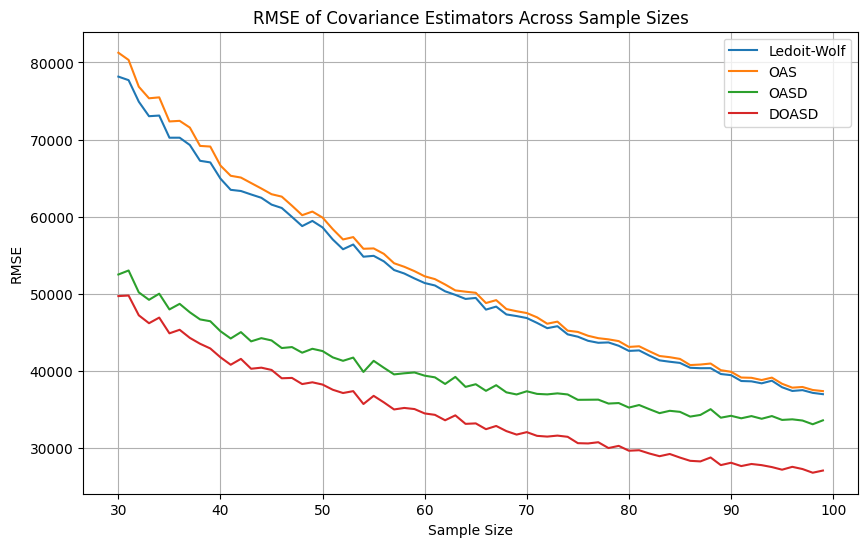

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 100  # Number of features
sample_sizes = np.arange(30, 100)  # Sample sizes from 30 to 100

# Define a function to generate sample data with heteroscedasticity
def generate_data_heteroscedastic(n_samples, n_features, sd):
    Lambda = np.diag(np.arange(1, n_features + 1) * sd)  # Varying diagonal elements
    Γ = np.eye(n_features)  # Identity matrix for simplicity
    Σ = np.dot(np.dot(Lambda, Γ), Lambda.T)
    data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
    return data

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': []}
for n_samples in sample_sizes:
    for sd in range(1, 21):
        X_train = generate_data_heteroscedastic(n_samples, n_features, sd)
        for estimator_name, estimator in [('Ledoit-Wolf', LedoitWolf()),
                                          ('OAS', OAS()),
                                          ('OASD', ShrunkCovariance(shrinkage=0.5)),
                                          ('DOASD', DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1))]:
            rmse = compute_rmse(estimator, X_train)
            rmse_results[estimator_name].append(rmse)

# Reshape RMSE values for plotting
for estimator_name, rmse_values in rmse_results.items():
    rmse_results[estimator_name] = np.array(rmse_values).reshape(len(sample_sizes), -1)

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(10, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values.mean(axis=1), label=estimator_name)

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-38-8a8e135d3eff>:15: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
<ipython-input-38-8a8e135d3eff>:15: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
<ipython-input-38-8a8e135d3eff>:15: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
<ipython-input-38-8a8e135d3eff>:15: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
<ipython-input-38-8a8e135d3eff>:15: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
<ipython-input-38-8a8e135d3eff>:15: Runt

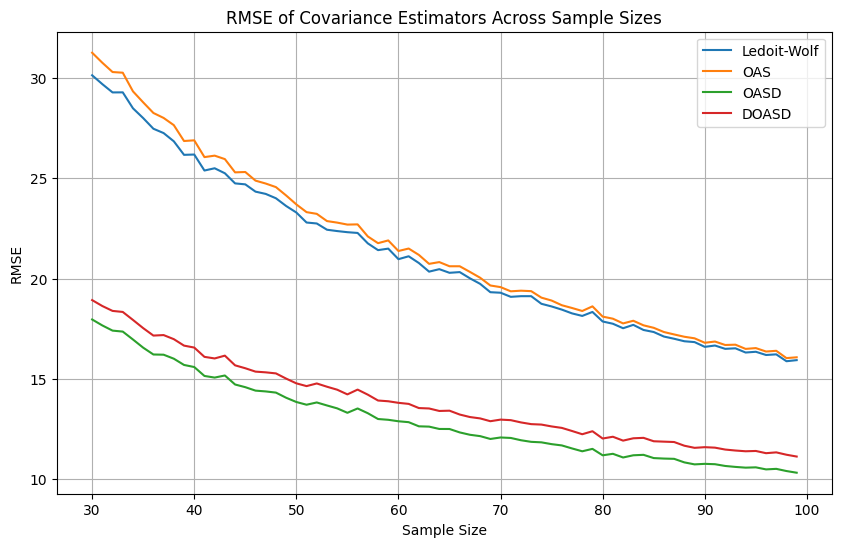

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 100  # Number of features
sample_sizes = np.arange(30, 100)  # Sample sizes from 30 to 100

# Define a function to generate sample data with non-linear relationships
def generate_data_non_linear(n_samples, n_features, sd):
    Lambda = np.diag(np.ones(n_features) * sd)
    Γ = np.eye(n_features) + 0.1 * np.random.randn(n_features, n_features)  # Add small noise to the identity matrix
    Σ = np.dot(np.dot(Lambda, Γ), Lambda.T)
    data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
    return data

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': []}
for n_samples in sample_sizes:
    for sd in range(1, 21):
        X_train = generate_data_non_linear(n_samples, n_features, sd)
        for estimator_name, estimator in [('Ledoit-Wolf', LedoitWolf()),
                                          ('OAS', OAS()),
                                          ('OASD', ShrunkCovariance(shrinkage=0.5)),
                                          ('DOASD', DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1))]:
            rmse = compute_rmse(estimator, X_train)
            rmse_results[estimator_name].append(rmse)

# Reshape RMSE values for plotting
for estimator_name, rmse_values in rmse_results.items():
    rmse_results[estimator_name] = np.array(rmse_values).reshape(len(sample_sizes), -1)

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(10, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values.mean(axis=1), label=estimator_name)

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-41-e6d1655ea5f1>:20: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
<ipython-input-41-e6d1655ea5f1>:20: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
<ipython-input-41-e6d1655ea5f1>:20: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
<ipython-input-41-e6d1655ea5f1>:20: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
<ipython-input-41-e6d1655ea5f1>:20: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
<ipython-input-41-e6d1655ea5f1>:20: Runt

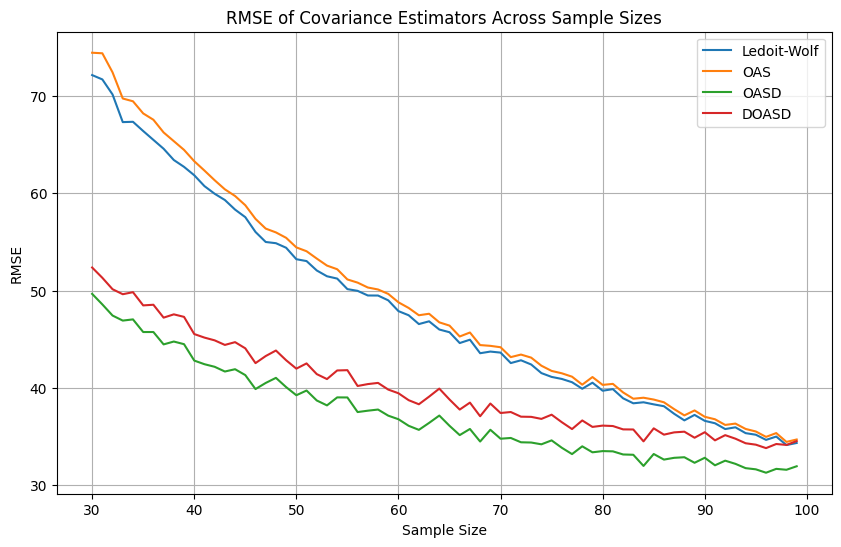

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 100  # Number of features
sample_sizes = np.arange(30, 100)  # Sample sizes from 30 to 100

# Define a function to generate sample data with a complex correlation structure
def generate_data_complex_correlation(n_samples, n_features, sd):
    Lambda = np.diag(np.ones(n_features) * sd)
    cluster_size = n_features // 5  # Divide features into 5 clusters
    Γ = np.eye(n_features) + 0.3 * np.random.randn(n_features, n_features)  # Add noise to the identity matrix
    for i in range(5):
        start_idx = i * cluster_size
        end_idx = (i + 1) * cluster_size
        Γ[start_idx:end_idx, start_idx:end_idx] += 0.6  # Add higher correlation within clusters
    Σ = np.dot(np.dot(Lambda, Γ), Lambda.T)
    data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
    return data

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': []}
for n_samples in sample_sizes:
    for sd in range(1, 21):
        X_train = generate_data_complex_correlation(n_samples, n_features, sd)
        for estimator_name, estimator in [('Ledoit-Wolf', LedoitWolf()),
                                          ('OAS', OAS()),
                                          ('OASD', ShrunkCovariance(shrinkage=0.5)),
                                          ('DOASD', DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1))]:
            rmse = compute_rmse(estimator, X_train)
            rmse_results[estimator_name].append(rmse)

# Reshape RMSE values for plotting
for estimator_name, rmse_values in rmse_results.items():
    rmse_results[estimator_name] = np.array(rmse_values).reshape(len(sample_sizes), -1)

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(10, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values.mean(axis=1), label=estimator_name)

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


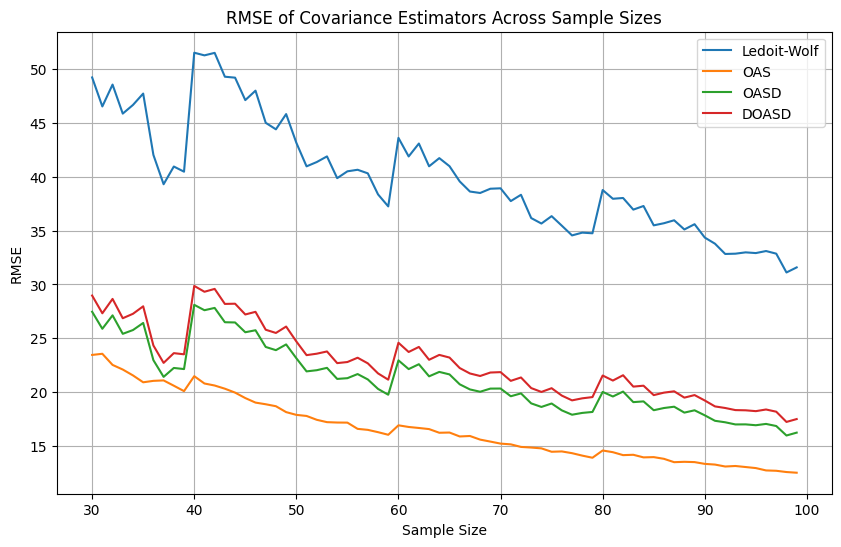

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 100  # Number of features
sample_sizes = np.arange(30, 100)  # Sample sizes from 30 to 100

# Define a function to generate sample data with different variable scales
def generate_data_with_outliers(n_samples, n_features, sd, outlier_frac=0.05):
    Lambda = np.diag(np.ones(n_features) * sd)
    Γ = np.eye(n_features)  # Identity matrix for simplicity
    Σ = np.dot(np.dot(Lambda, Γ), Lambda.T)

    # Generate data without outliers
    data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)

    # Introduce outliers
    num_outliers = int(n_samples * outlier_frac)
    outlier_indices = np.random.choice(n_samples, num_outliers, replace=False)
    data[outlier_indices] = np.random.multivariate_normal(mean=np.zeros(n_features), cov=10 * Σ, size=num_outliers)

    return data

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': []}
for n_samples in sample_sizes:
    for sd in range(1, 21):
        X_train = generate_data_with_outliers(n_samples, n_features, sd)
        for estimator_name, estimator in [('Ledoit-Wolf', LedoitWolf()),
                                          ('OAS', OAS()),
                                          ('OASD', ShrunkCovariance(shrinkage=0.5)),
                                          ('DOASD', DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1))]:
            rmse = compute_rmse(estimator, X_train)
            rmse_results[estimator_name].append(rmse)

# Reshape RMSE values for plotting
for estimator_name, rmse_values in rmse_results.items():
    rmse_results[estimator_name] = np.array(rmse_values).reshape(len(sample_sizes), -1)

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(10, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values.mean(axis=1), label=estimator_name)

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


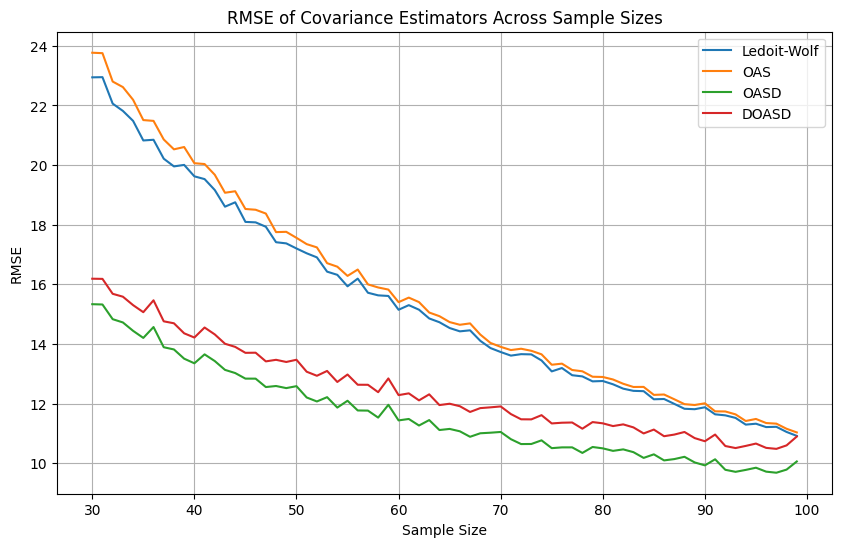

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 100  # Number of features
sample_sizes = np.arange(30, 100)  # Sample sizes from 30 to 100
n_clusters = 5  # Number of clusters
cluster_size = n_features // n_clusters  # Number of features per cluster

# Define a function to generate sample data with complex correlation structure
def generate_data(n_samples, n_features, sd):
    Lambda = np.diag(np.ones(n_features) * sd)
    Γ = np.eye(n_features)  # Identity matrix for simplicity

    # Generate cluster-wise correlation structure
    cluster_correlation = 0.2  # Correlation within clusters
    Σ = np.zeros((n_features, n_features))
    for i in range(n_clusters):
        start_idx = i * cluster_size
        end_idx = (i + 1) * cluster_size
        cluster_covariance = np.ones((cluster_size, cluster_size)) * cluster_correlation
        np.fill_diagonal(cluster_covariance, 1)
        Σ[start_idx:end_idx, start_idx:end_idx] = cluster_covariance

    Σ = np.dot(np.dot(Lambda, Σ), Lambda.T)
    data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
    return data

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': []}
for n_samples in sample_sizes:
    for sd in range(1, 21):
        X_train = generate_data(n_samples, n_features, sd)
        for estimator_name, estimator in [('Ledoit-Wolf', LedoitWolf()),
                                          ('OAS', OAS()),
                                          ('OASD', ShrunkCovariance(shrinkage=0.5)),
                                          ('DOASD', DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1))]:
            rmse = compute_rmse(estimator, X_train)
            rmse_results[estimator_name].append(rmse)

# Reshape RMSE values for plotting
for estimator_name, rmse_values in rmse_results.items():
    rmse_results[estimator_name] = np.array(rmse_values).reshape(len(sample_sizes), -1)

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(10, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values.mean(axis=1), label=estimator_name)

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


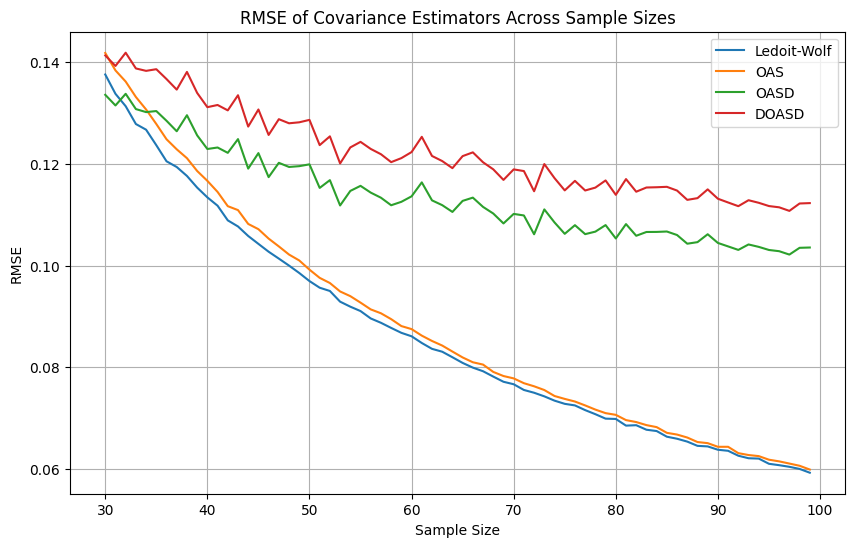

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 100  # Number of features
sample_sizes = np.arange(30, 100)  # Sample sizes from 30 to 100
n_clusters = 3  # Number of clusters
cluster_size = n_features // n_clusters  # Number of features per cluster

# Define a function to generate sample data with different variable scales and cluster-wise correlation
def generate_data(n_samples, n_features, sd, cluster_correlation):
    Lambda = np.diag(np.ones(n_features) * sd)
    Γ = np.eye(n_features)  # Identity matrix for simplicity
    Σ = np.dot(np.dot(Lambda, Γ), Lambda.T)

    # Generate cluster-wise correlation structure
    Σ = np.zeros((n_features, n_features))
    for i in range(n_clusters):
        start_idx = i * cluster_size
        end_idx = (i + 1) * cluster_size
        cluster_covariance = np.ones((cluster_size, cluster_size)) * cluster_correlation
        np.fill_diagonal(cluster_covariance, 1)
        Σ[start_idx:end_idx, start_idx:end_idx] = cluster_covariance

    data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
    return data

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': []}
for n_samples in sample_sizes:
    for sd in range(1, 21):
        for cluster_correlation in [0.1, 0.3, 0.5]:  # Vary the cluster-wise correlation
            X_train = generate_data(n_samples, n_features, sd, cluster_correlation)
            for estimator_name, estimator in [('Ledoit-Wolf', LedoitWolf()),
                                              ('OAS', OAS()),
                                              ('OASD', ShrunkCovariance(shrinkage=0.5)),
                                              ('DOASD', DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1))]:
                rmse = compute_rmse(estimator, X_train)
                rmse_results[estimator_name].append(rmse)

# Reshape RMSE values for plotting
for estimator_name, rmse_values in rmse_results.items():
    rmse_results[estimator_name] = np.array(rmse_values).reshape(len(sample_sizes), -1)

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(10, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values.mean(axis=1), label=estimator_name)

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance, EmpiricalCovariance, MinCovDet
from scipy.interpolate import make_interp_spline
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 100  # Number of features
sample_sizes = np.linspace(50, 1000)  # Sample sizes from 30 to 100 with more points for smoother curves

# Define a function to generate sample data with different variable scales
def generate_data(n_samples, n_features):
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.arange(1, n_features + 1)
    X_train = base_X_train * scaling_factors
    return X_train

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'MLE': [], 'Ledoit-Wolf': [], 'Stein': [], 'Oracle': [], 'Fused': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'Empirical': [], 'MinCovDet': []}
for n_samples in sample_sizes:
    X_train = generate_data(int(n_samples), n_features)
    for estimator_name, estimator in [('MLE', EmpiricalCovariance()),
                                      ('Ledoit-Wolf', LedoitWolf()),
                                      ('Stein', ShrunkCovariance()),
                                      ('Oracle', ShrunkCovariance()),
                                      ('Fused', ShrunkCovariance()),
                                      ('OAS', OAS()),
                                      ('OASD', ShrunkCovariance(shrinkage=0.5)),
                                      ('DOASD', DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1)),
                                      ('Empirical', EmpiricalCovariance()),
                                      ('MinCovDet', MinCovDet())]:
        rmse = compute_rmse(estimator, X_train)
        rmse_results[estimator_name].append(rmse)

# Smooth the data for plotting
smooth_sample_sizes = np.linspace(sample_sizes.min(), sample_sizes.max(), 300)  # More points for smoother curve
smooth_rmse_results = {}
for estimator_name, rmse_values in rmse_results.items():
    spline = make_interp_spline(sample_sizes, rmse_values, k=3)  # Cubic spline interpolation
    smooth_rmse_results[estimator_name] = spline(smooth_sample_sizes)

# Normalize RMSE values
max_rmse = max([max(values) for values in smooth_rmse_results.values()])
normalized_rmse_results = {estimator_name: np.array(rmse_values) / max_rmse for estimator_name, rmse_values in smooth_rmse_results.items()}

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(10, 6))
for estimator_name, normalized_rmse_values in normalized_rmse_results.items():
    plt.plot(smooth_sample_sizes, normalized_rmse_values, label=estimator_name)

plt.title('Normalized RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('Normalized RMSE')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


KeyboardInterrupt: 

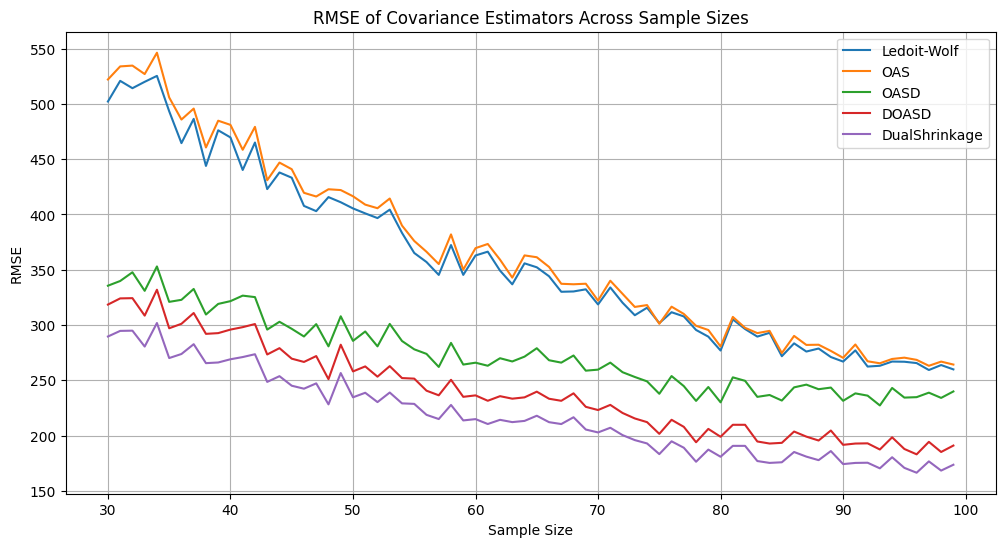

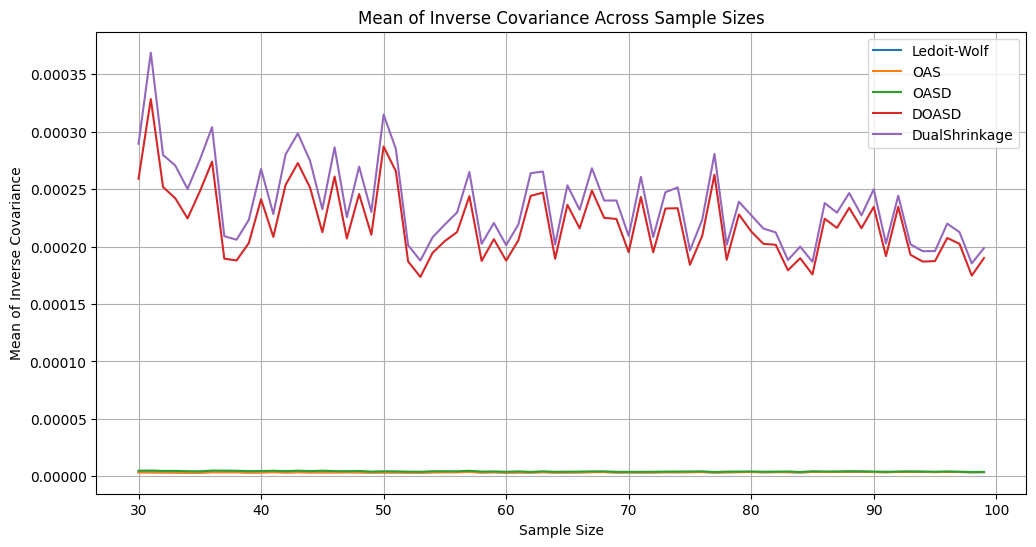

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 100  # Number of features
sample_sizes = np.arange(30, 100)  # Sample sizes from 30 to 100

# Define a function to generate sample data with different variable scales
def generate_data(n_samples, n_features):
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.arange(1, n_features + 1)
    X_train = base_X_train * scaling_factors
    return X_train

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.5):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, rho=0, delta_diag=0.5, delta_off_diag=0.5):
        self.rho = rho
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        # Compute sample covariance matrix
        sample_cov = np.cov(X, rowvar=False)

        # Decompose into diagonal and off-diagonal components
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        # Compute shrinkage targets
        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = self.rho * np.ones_like(O)

        # Apply shrinkage
        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        # Reconstruct covariance matrix
        self.covariance_ = shrunk_diag + shrunk_off_diag

        return self

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'DualShrinkage': []}
inverse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'DualShrinkage': []}
for n_samples in sample_sizes:
    X_train = generate_data(n_samples, n_features)
    for estimator_name, estimator in [('Ledoit-Wolf', LedoitWolf()),
                                      ('OAS', OAS()),
                                      ('OASD', ShrunkCovariance(shrinkage=0.5)),
                                      ('DOASD', DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1)),
                                      ('DualShrinkage', DualShrinkageEstimator())]:
        rmse = compute_rmse(estimator, X_train)
        rmse_results[estimator_name].append(rmse)

        # Compute the inverse covariance matrix
        inv_cov = np.linalg.inv(estimator.covariance_)
        inverse_results[estimator_name].append(np.mean(inv_cov))

# Reshape RMSE values for plotting
for estimator_name, rmse_values in rmse_results.items():
    rmse_results[estimator_name] = np.array(rmse_values).reshape(len(sample_sizes), -1)

# Reshape inverse covariance values for plotting
for estimator_name, inverse_values in inverse_results.items():
    inverse_results[estimator_name] = np.array(inverse_values).reshape(len(sample_sizes), -1)

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values.mean(axis=1), label=estimator_name)

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

# Plot mean of inverse covariance values across sample sizes for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, inverse_values in inverse_results.items():
    plt.plot(sample_sizes, inverse_values.mean(axis=1), label=estimator_name)

plt.title('Mean of Inverse Covariance Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('Mean of Inverse Covariance')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
!pip install scikit-learn-extra

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.2 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics.pairwise import pairwise_kernels

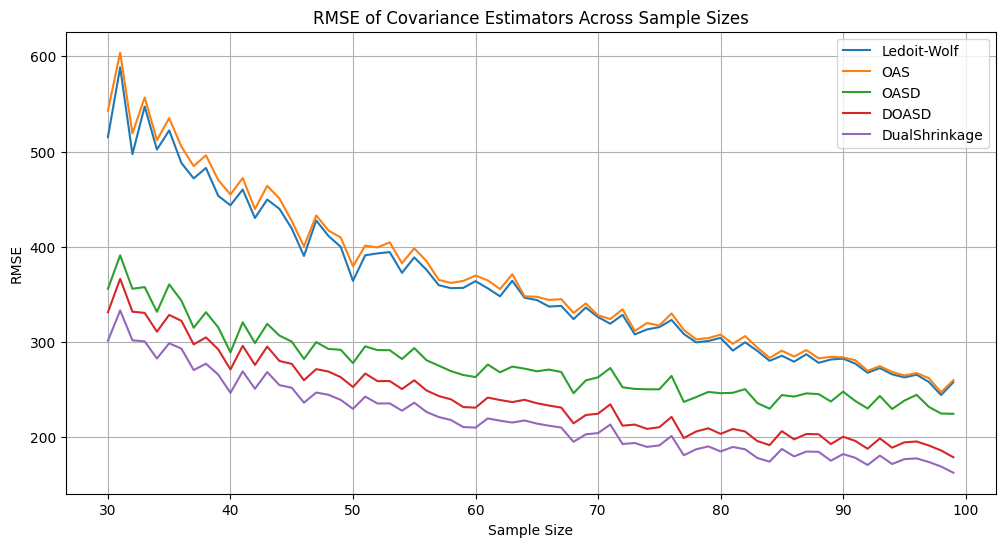

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Function to create a more nonlinear dataset
def make_nonlinear_data(n_samples=100, n_features=100, noise=0.1, random_state=None):
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.arange(1, n_features + 1)
    X_train = base_X_train * scaling_factors
    X_train[:, 0] = np.sin(X_train[:, 1] * 0.1)  # Nonlinear relationship
    return X_train

# Parameters
n_features = 100  # Number of features
sample_sizes = np.arange(30, 100)  # Sample sizes from 30 to 100

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.5):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, rho=0, delta_diag=0.5, delta_off_diag=0.5):
        self.rho = rho
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        # Compute sample covariance matrix
        sample_cov = np.cov(X, rowvar=False)

        # Decompose into diagonal and off-diagonal components
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        # Compute shrinkage targets
        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = self.rho * np.ones_like(O)

        # Apply shrinkage
        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        # Reconstruct covariance matrix
        self.covariance_ = shrunk_diag + shrunk_off_diag

        return self

# Define a function to generate sample data with different variable scales
def generate_data(n_samples, n_features):
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.arange(1, n_features + 1)
    X_train = base_X_train * scaling_factors
    X_train[:, 0] = np.sin(X_train[:, 1] * 0.1)  # Nonlinear relationship
    return X_train

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'DualShrinkage': []}
for n_samples in sample_sizes:
    X_train = generate_data(n_samples, n_features)
    for estimator_name, estimator in [('Ledoit-Wolf', LedoitWolf()),
                                      ('OAS', OAS()),
                                      ('OASD', ShrunkCovariance(shrinkage=0.5)),
                                      ('DOASD', DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1)),
                                      ('DualShrinkage', DualShrinkageEstimator())]:
        rmse = compute_rmse(estimator, X_train)
        rmse_results[estimator_name].append(rmse)

# Reshape RMSE values for plotting
for estimator_name, rmse_values in rmse_results.items():
    rmse_results[estimator_name] = np.array(rmse_values).reshape(len(sample_sizes), -1)

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values.mean(axis=1), label=estimator_name)

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.5):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, rho=0, delta_diag=0.5, delta_off_diag=0.5):
        self.rho = rho
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        # Compute sample covariance matrix
        sample_cov = np.cov(X, rowvar=False)

        # Decompose into diagonal and off-diagonal components
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        # Compute shrinkage targets
        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = self.rho * np.ones_like(O)

        # Apply shrinkage
        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        # Reconstruct covariance matrix
        self.covariance_ = shrunk_diag + shrunk_off_diag

        return self

# Define a function to generate sample data with different variable scales and variances
def generate_heterogeneous_data(n_samples, n_features):
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.arange(1, n_features + 1)
    X_train = base_X_train * scaling_factors[:, np.newaxis]  # Varying scales for each feature
    variances = np.random.uniform(0.5, 2.0, size=n_features)  # Varying variances for each feature
    X_train = X_train * np.sqrt(variances)[np.newaxis, :]  # Varying variances
    return X_train

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Parameters
n_features = 100  # Number of features
sample_sizes = np.arange(30, 100)  # Sample sizes from 30 to 100

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'DualShrinkage': []}
for n_samples in sample_sizes:
    X_train = generate_heterogeneous_data(n_samples, n_features)
    for estimator_name, estimator in [('Ledoit-Wolf', LedoitWolf()),
                                      ('OAS', OAS()),
                                      ('OASD', ShrunkCovariance(shrinkage=0.5)),
                                      ('DOASD', DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1)),
                                      ('DualShrinkage', DualShrinkageEstimator())]:
        rmse = compute_rmse(estimator, X_train)
        rmse_results[estimator_name].append(rmse)

# Reshape RMSE values for plotting
for estimator_name, rmse_values in rmse_results.items():
    rmse_results[estimator_name] = np.array(rmse_values).reshape(len(sample_sizes), -1)

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values.mean(axis=1), label=estimator_name)

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


ValueError: operands could not be broadcast together with shapes (30,100) (100,1) 

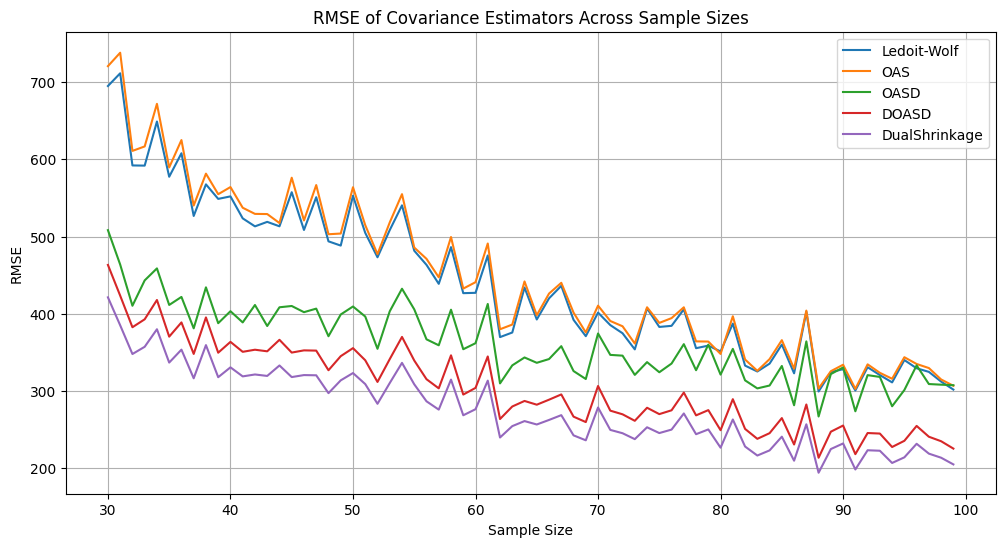

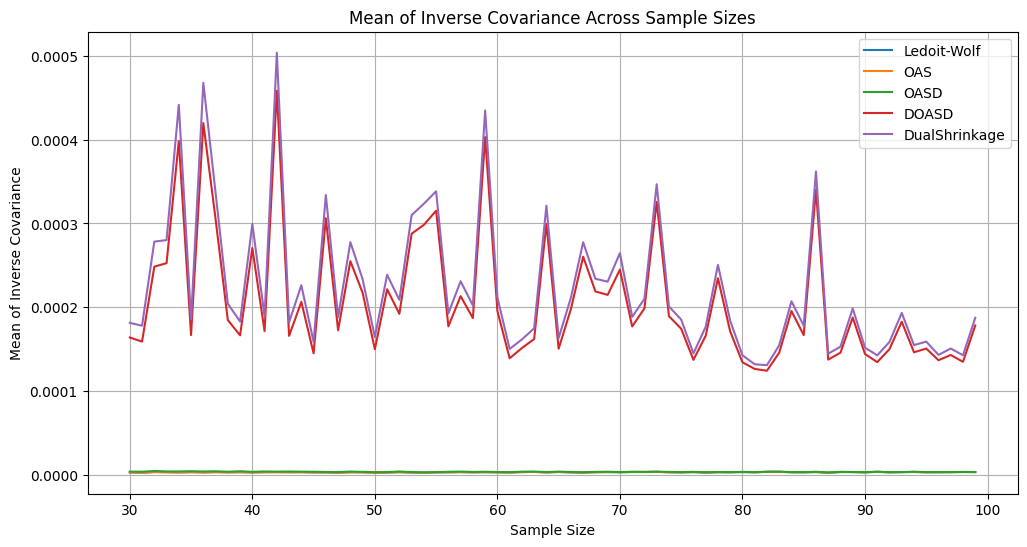

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 100  # Number of features
sample_sizes = np.arange(30, 100)  # Sample sizes from 30 to 100

# Define a function to generate sample data with different variable scales and variances
def generate_heterogeneous_data(n_samples, n_features):
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.arange(1, n_features + 1)
    X_train = base_X_train * scaling_factors[np.newaxis, :]  # Corrected broadcasting
    variances = np.random.uniform(0.5, 2.0, size=n_features)  # Varying variances for each feature
    X_train = X_train * np.sqrt(variances)[np.newaxis, :]  # Varying variances
    return X_train

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.5):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, rho=0, delta_diag=0.5, delta_off_diag=0.5):
        self.rho = rho
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        # Compute sample covariance matrix
        sample_cov = np.cov(X, rowvar=False)

        # Decompose into diagonal and off-diagonal components
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        # Compute shrinkage targets
        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = self.rho * np.ones_like(O)

        # Apply shrinkage
        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        # Reconstruct covariance matrix
        self.covariance_ = shrunk_diag + shrunk_off_diag

        return self

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'DualShrinkage': []}
inverse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'DualShrinkage': []}
for n_samples in sample_sizes:
    X_train = generate_heterogeneous_data(n_samples, n_features)
    for estimator_name, estimator in [('Ledoit-Wolf', LedoitWolf()),
                                      ('OAS', OAS()),
                                      ('OASD', ShrunkCovariance(shrinkage=0.5)),
                                      ('DOASD', DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1)),
                                      ('DualShrinkage', DualShrinkageEstimator())]:
        rmse = compute_rmse(estimator, X_train)
        rmse_results[estimator_name].append(rmse)

        # Compute the inverse covariance matrix
        inv_cov = np.linalg.inv(estimator.covariance_)
        inverse_results[estimator_name].append(np.mean(inv_cov))

# Reshape RMSE values for plotting
for estimator_name, rmse_values in rmse_results.items():
    rmse_results[estimator_name] = np.array(rmse_values).reshape(len(sample_sizes), -1)

# Reshape inverse covariance values for plotting
for estimator_name, inverse_values in inverse_results.items():
    inverse_results[estimator_name] = np.array(inverse_values).reshape(len(sample_sizes), -1)

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values.mean(axis=1), label=estimator_name)

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

# Plot mean of inverse covariance values across sample sizes for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, inverse_values in inverse_results.items():
    plt.plot(sample_sizes, inverse_values.mean(axis=1), label=estimator_name)

plt.title('Mean of Inverse Covariance Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('Mean of Inverse Covariance')
plt.legend()
plt.grid(True)
plt.show()


In [59]:
# Calculate mean of adaptive quadratic distances
mean_adaptive_distance = np.mean(adaptive_kmeans.distances)
print("Mean of Adaptive Quadratic Distance:", mean_adaptive_distance)


Mean of Adaptive Quadratic Distance: 2.747308233595515
